# Objectives

1. Estimate Clock Model
1. Filter Outliers
    - Plot Prune Compare: Divtree
    - Plot Prune Compare: Timetree
1. Add Clock Model to Dataframe

NOTE: Filter outliers after clock model estimated?

---
# Setup

## Modules

In [53]:
# Bio
import treetime
from Bio import Phylo,AlignIO, Align,SeqIO
from ete3 import Tree

# Plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
sns.set_style('whitegrid')

# Stats
import pandas as pd

# System IO
import dill
import copy
import os
import io
import sys

## Variables

In [2]:
from config import *

# Custom script variables
SCRIPT_NAME = "clock"
PREV_DIR_NAME = "parse_tree"
PREV_SCRIPT_NAME = "parse_tree"

try:
    WILDCARDS = snakemake.wildcards
    project_dir = os.getcwd()
except NameError:
    WILDCARDS = ["all", "chromosome", "50"]
    project_dir = os.path.dirname(os.path.dirname(os.getcwd()))
READS_ORIGIN = WILDCARDS[0]
LOCUS_NAME = WILDCARDS[1]
MISSING_DATA = WILDCARDS[2]

NAME_COL = "Name"

## Paths

In [3]:
results_dir = os.path.join(project_dir, "results")
config_dir = os.path.join(results_dir, "config")


outdir       = os.path.join(results_dir, SCRIPT_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA),)
tree_dill    = os.path.join(results_dir, PREV_DIR_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA),PREV_SCRIPT_NAME + ".phylo.obj")
tree_df_dill = os.path.join(results_dir, PREV_DIR_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), PREV_SCRIPT_NAME + ".df.obj")
tree_df_path = os.path.join(results_dir, PREV_DIR_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), PREV_SCRIPT_NAME + ".tsv")
aln_path     = os.path.join(results_dir,"snippy_multi",READS_ORIGIN,"snippy-core_{}.snps.filter{}.aln".format(LOCUS_NAME, MISSING_DATA))


# Auspice
auspice_latlon_path = os.path.join(results_dir, "parse_tree", READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), "parse_tree" + "_lat-lon_auspice.tsv")
auspice_colors_path = os.path.join(results_dir, "parse_tree", READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), "parse_tree" + "_colors.tsv")
auspice_config_path = os.path.join(config_dir, "auspice_config.json")
auspice_remote_dir_path = os.path.join(project_dir, "auspice/")

constant_sites_path = os.path.join(results_dir,"snippy_multi",READS_ORIGIN,"snippy-core_chromosome.full.constant_sites.txt")


print("tree_dill:\t", tree_dill)
print("tree_df_dill:\t", tree_df_dill)
print("aln path:\t", aln_path)
print("auspice_latlon_path:", auspice_latlon_path)
print("auspice_colors_path:", auspice_colors_path)
print("auspice_config_path:", auspice_config_path)
print("auspice_remote_dir_path:", auspice_remote_dir_path)
print("outdir:", outdir)

# Create output directory if it doesn't exist
while not os.path.exists(outdir):
    os.makedirs(outdir)   
    
SCRIPT_NAME = "clock_model"

tree_dill:	 /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/parse_tree/all/chromosome_filter50/parse_tree.phylo.obj
tree_df_dill:	 /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/parse_tree/all/chromosome_filter50/parse_tree.df.obj
aln path:	 /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/snippy_multi/all/snippy-core_chromosome.snps.filter50.aln
auspice_latlon_path: /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/parse_tree/all/chromosome_filter50/parse_tree_lat-lon_auspice.tsv
auspice_colors_path: /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/parse_tree/all/chromosome_filter50/parse_tree_colors.tsv
auspice_config_path: /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/config/auspice_config.json
auspice_remote_dir_path: /mnt/c/Users/ktmea/Projects/plague-phylogeography/auspice/
outdir: /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/clock/all/chromosome_filter50


## Import Tree

In [4]:
with open(tree_dill, "rb") as infile:
    tree = dill.load(infile)
tree.ladderize(reverse=False)

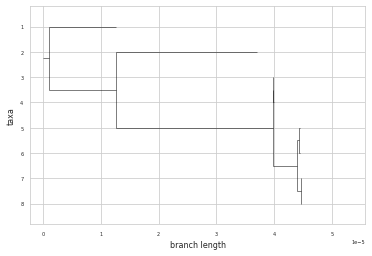

In [5]:
tree.root.branch_length = 1e-6
Phylo.draw(tree,   show_confidence=False, label_func = lambda x: '', do_show=False)  

## Import Dataframe

In [6]:
with open(tree_df_dill, "rb") as infile:
    tree_df = dill.load(infile)
tree_df

,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number
Name,,,,,,,,,,,,,,,,,,,,,
NODE0,NA,NA,0.000000e+00,black,0.000000,2.25,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Reference,NA,NA,1.153650e-05,grey,0.000012,1.00,NA,1992,-29,United States of America,Colorado,39.7837,-100.446,38.7252,-105.608,Orientalis,1.ORI,1.ORI1,NA,KEEP: Assembly Modern Reference,1
NODE1,NA,NA,1.153650e-05,black,0.000012,3.50,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
GCA_009909635.1_ASM990963v1_genomic,NA,NA,2.447080e-05,grey,0.000036,2.00,9_10,1923,-98,Russia,Rostov Oblast,64.6863,97.7453,47.6222,40.7958,Medievalis,2.MED,2.MED1,SAMN13632815,KEEP: Assembly Modern,2
NODE2,NA,NA,2.721210e-05,black,0.000039,5.00,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SAMN02442718,NA,NA,2.330000e-08,grey,0.000043,5.00,Justinian,[500:800],[-1521:-1221],Germany,Bavaria,51.0834,10.4234,48.9468,11.4039,Orientalis,0.ANT,0.ANT4,SAMN02442718,KEEP: Ancient SRA,0
testlocal1,NA,NA,2.330000e-08,grey,0.000043,6.00,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NODE6,NA,NA,7.052000e-07,black,0.000044,7.50,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


## Import Constant Sites

In [7]:
with open(constant_sites_path, "r") as infile:
    constant_sites_str = infile.read().strip().split(",")
    constant_sites_list = [int(c) for c in constant_sites_str]
    constant_sites = sum(constant_sites_list)
    constant_sites_freq = [c/constant_sites for c in constant_sites_list]
    fixed_pi = np.array(constant_sites_freq)

# 1. Filter Outlier Tips

## Parse Tip Dates

In [8]:
# Use the utils function to parse the metadata dates
dates_raw = treetime.utils.parse_dates(tree_df_path, 
                                   date_col=DATE_COL, 
                                   name_col = NAME_COL)

# Remove nan elements (internal nodes)
dates = {}
for k,v in dates_raw.items():
    if type(v) == list:
        dates[k] = v
    elif not pd.isnull(v):
        dates[k] = v
        
# Add Reference
dates["Reference"] = REF_DATE


Attempting to parse dates...
	Using column 'Name' as name. This needs match the taxon names in the tree!!
	Using column 'Date' as date.


---
# 1. Estimate Clock Model

## Initialize treetime object

In [9]:
tt = treetime.TreeTime(
    dates=dates,
    aln=aln_path,
    tree=tree,
    verbose=2,
    fill_overhangs=False,
    seq_len=REF_LEN,
    alphabet="nuc_nogap",
)


0.00	-TreeAnc: set-up

0.02	-SequenceData: loaded alignment.
0.02	--SequenceData.aln: specified sequence length doesn't match alignment
    	  length. Treating difference as constant sites.

0.02	-SeqData: making compressed alignment...

1.31	-SequenceData: constructed compressed alignment...

1.39	-ClockTree._assign_dates: assigned date contraints to 6 out of 8 tips.


## Estimate the clock model

In [10]:
#tt.run(max_iter=10, Tc="skyline")
tt.run(
    n_iqd=3,
    infer_gtr=True,
    relaxed_clock={"slack" : 0.1, "coupling": 0},
    branch_length_mode = "joint", # joint or marginal
    time_marginal=True,   # True, False or "assign"
    # Testing
    Tc="skyline",
    max_iter=1,
    #max_iter=50,
    root=tt.tree.root,    
    fixed_pi=fixed_pi,
    resolve_polytomies=False,    
    use_covariation=False,    
    vary_rate=False,    
)

# Order nodes
tt.tree.ladderize(reverse=False)

# Add extra length to root
tt_orig = copy.deepcopy(tt)


1.41	-TreeAnc.optimize_tree: sequences...

1.41	-TreeAnc.infer_ancestral_sequences with method: probabilistic, joint

1.41	WARNING: Previous versions of TreeTime (<0.7.0) RECONSTRUCTED sequences of
    	tips at positions with AMBIGUOUS bases. This resulted in unexpected
    	behavior is some cases and is no longer done by default. If you want to
    	replace those ambiguous sites with their most likely state, rerun with
    	`reconstruct_tip_states=True` or `--reconstruct-tip-states`.

1.44	-GTR: with alphabet: ['A', 'C', 'G', 'T']

1.44	-GTR: model inference

1.45	-TreeAnc.optimize_branch_length: running branch length optimization using
    	 jointML ancestral sequences

1.53	-TreeAnc.prune_short_branches: pruning short branches (max prob at zero)...

1.53	-TreeAnc.infer_ancestral_sequences with method: probabilistic, joint

1.54	TreeTime.reroot: with method or node: NODE0

1.56	TreeTime.reroot: with method or node: NODE0

1.57	-TreeAnc.optimize_tree: sequences...

1.57	-TreeAnc.infe

In [11]:
#tt = copy.deepcopy(tt_orig)

## Quick Checks

In [12]:
# Common Ancestor
tt.tree.common_ancestor("NODE0")

Clade(_v=0, bad_branch=False, branch_length=0.001, clock_length=0.001, comment='&UFboot=NA,sCF=NA,Branch_Length=0.0,Branch_Support_Color=...', date='-1664-08-14', dist2root=0.0, mutation_length=0.001, name='NODE0', original_length=1e-06)

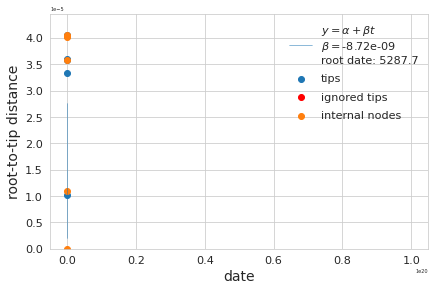

In [13]:
# RTT Regression
tt.plot_root_to_tip(add_internal=True, label=True)

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_rtt-pre." + FMT) 
plt.savefig(out_path, 
            dpi=dpi, 
            bbox_inches = "tight")

In [14]:
print(tt.gtr)

Substitution rate (mu): 1.0

Equilibrium frequencies (pi_i):
  A: 0.2627
  C: 0.2364
  G: 0.239
  T: 0.2619

Symmetrized rates from j->i (W_ij):
	A	C	G	T
  A	0	0.9953	2.5503	0.3491
  C	0.9953	0	0.3129	2.6277
  G	2.5503	0.3129	0	1.1771
  T	0.3491	2.6277	1.1771	0

Actual rates from j->i (Q_ij):
	A	C	G	T
  A	0	0.2615	0.6699	0.0917
  C	0.2353	0	0.074	0.6212
  G	0.6094	0.0748	0	0.2813
  T	0.0914	0.6883	0.3084	0



# 2. Filter Outliers

## Prune 'Bad' Branches from Tree

In [15]:
tt_pre = copy.deepcopy(tt)
tt_prune = copy.deepcopy(tt)

# Color branches and set to divtree
for n in tt_pre.tree.find_clades():
    n.branch_length=n.mutation_length
    if n.bad_branch:
        n.color = "red"
for n in tt_prune.tree.find_clades():
    n.branch_length=n.mutation_length

bad_nodes = [c for c in tt_prune.tree.find_clades() if c.bad_branch]

while len(bad_nodes) > 0:
    for node in bad_nodes:
        if node.is_terminal():
            print("PRUNING:", node.name)
            tt_prune.tree.prune(node)
    bad_nodes = [c for c in tt_prune.tree.find_clades() if c.bad_branch]

PRUNING: testlocal1
PRUNING: testlocal2


## Plot Prune Comparison: Divtree

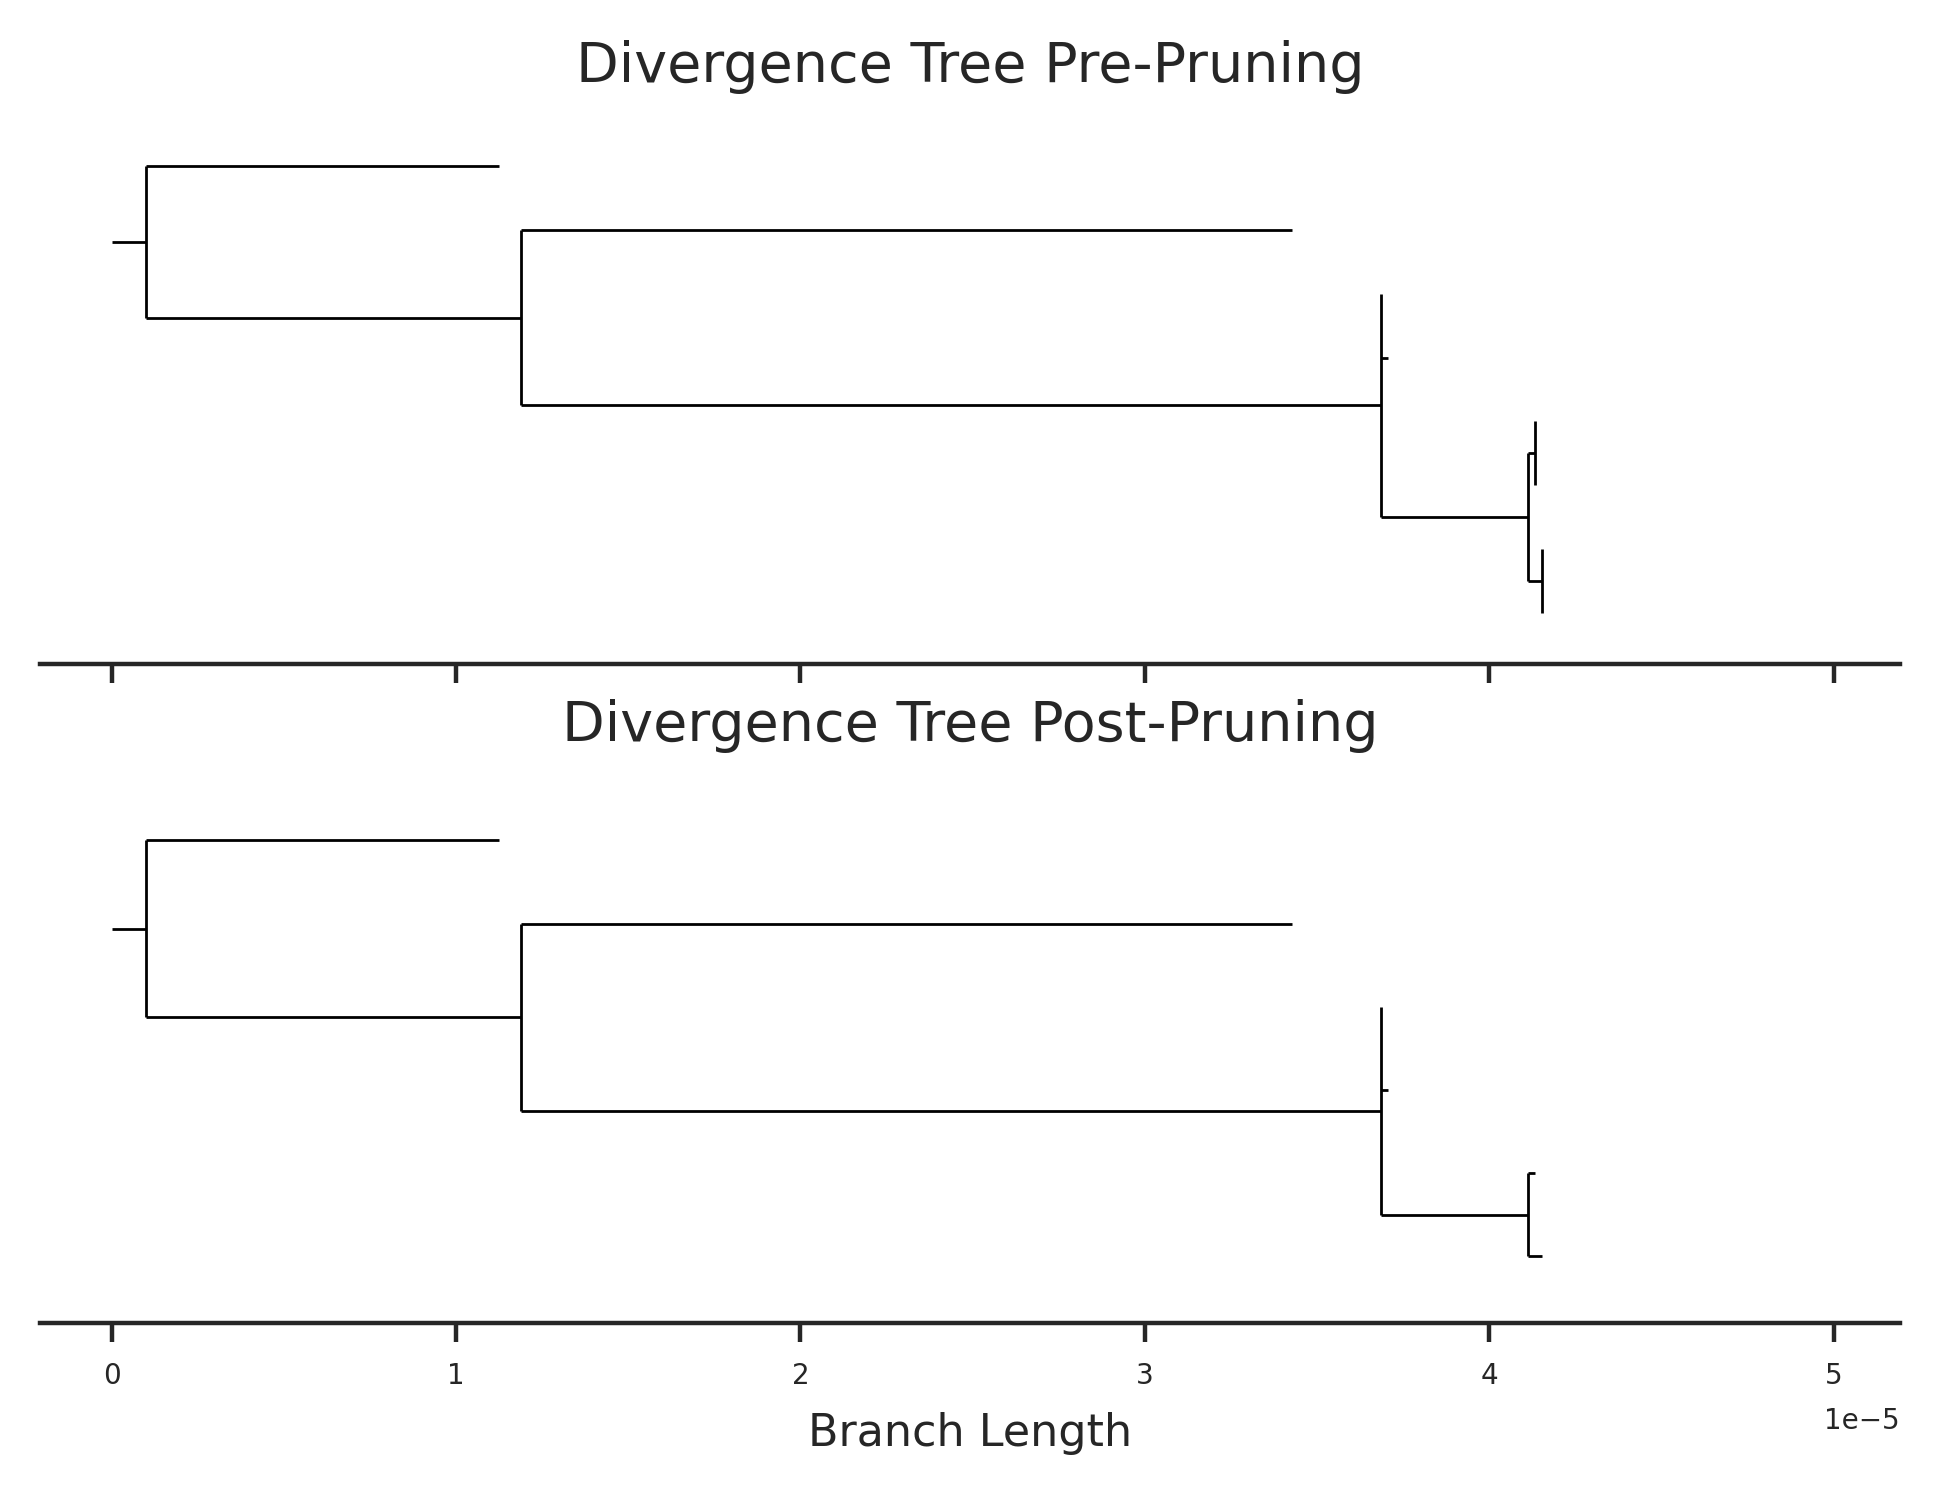

In [16]:
sns.set_style("ticks")
fig, (ax1,ax2) = plt.subplots(2, sharex=True, dpi=dpi)


tt_pre.tree.root.branch_length = 0.000001
tt_prune.tree.root.branch_length = 0.000001
Phylo.draw(tt_pre.tree,   show_confidence=False, label_func = lambda x: '', do_show=False, axes=ax1,)  
Phylo.draw(tt_prune.tree, show_confidence=False, label_func = lambda x: '', do_show=False, axes=ax2,)

ax1.set_title("Divergence Tree Pre-Pruning")
ax1.set_xlabel("")
ax1.set_ylabel("")
ax1.set_yticks([])
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["left"].set_visible(False)

ax2.set_title("Divergence Tree Post-Pruning")
ax2.set_xlabel("Branch Length")
ax2.set_ylabel("")
ax2.set_ylabel("")
ax2.set_yticks([])
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.spines["left"].set_visible(False)

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_divtree-prune." + FMT) 
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

## Plot Prune Comparison: Timetree

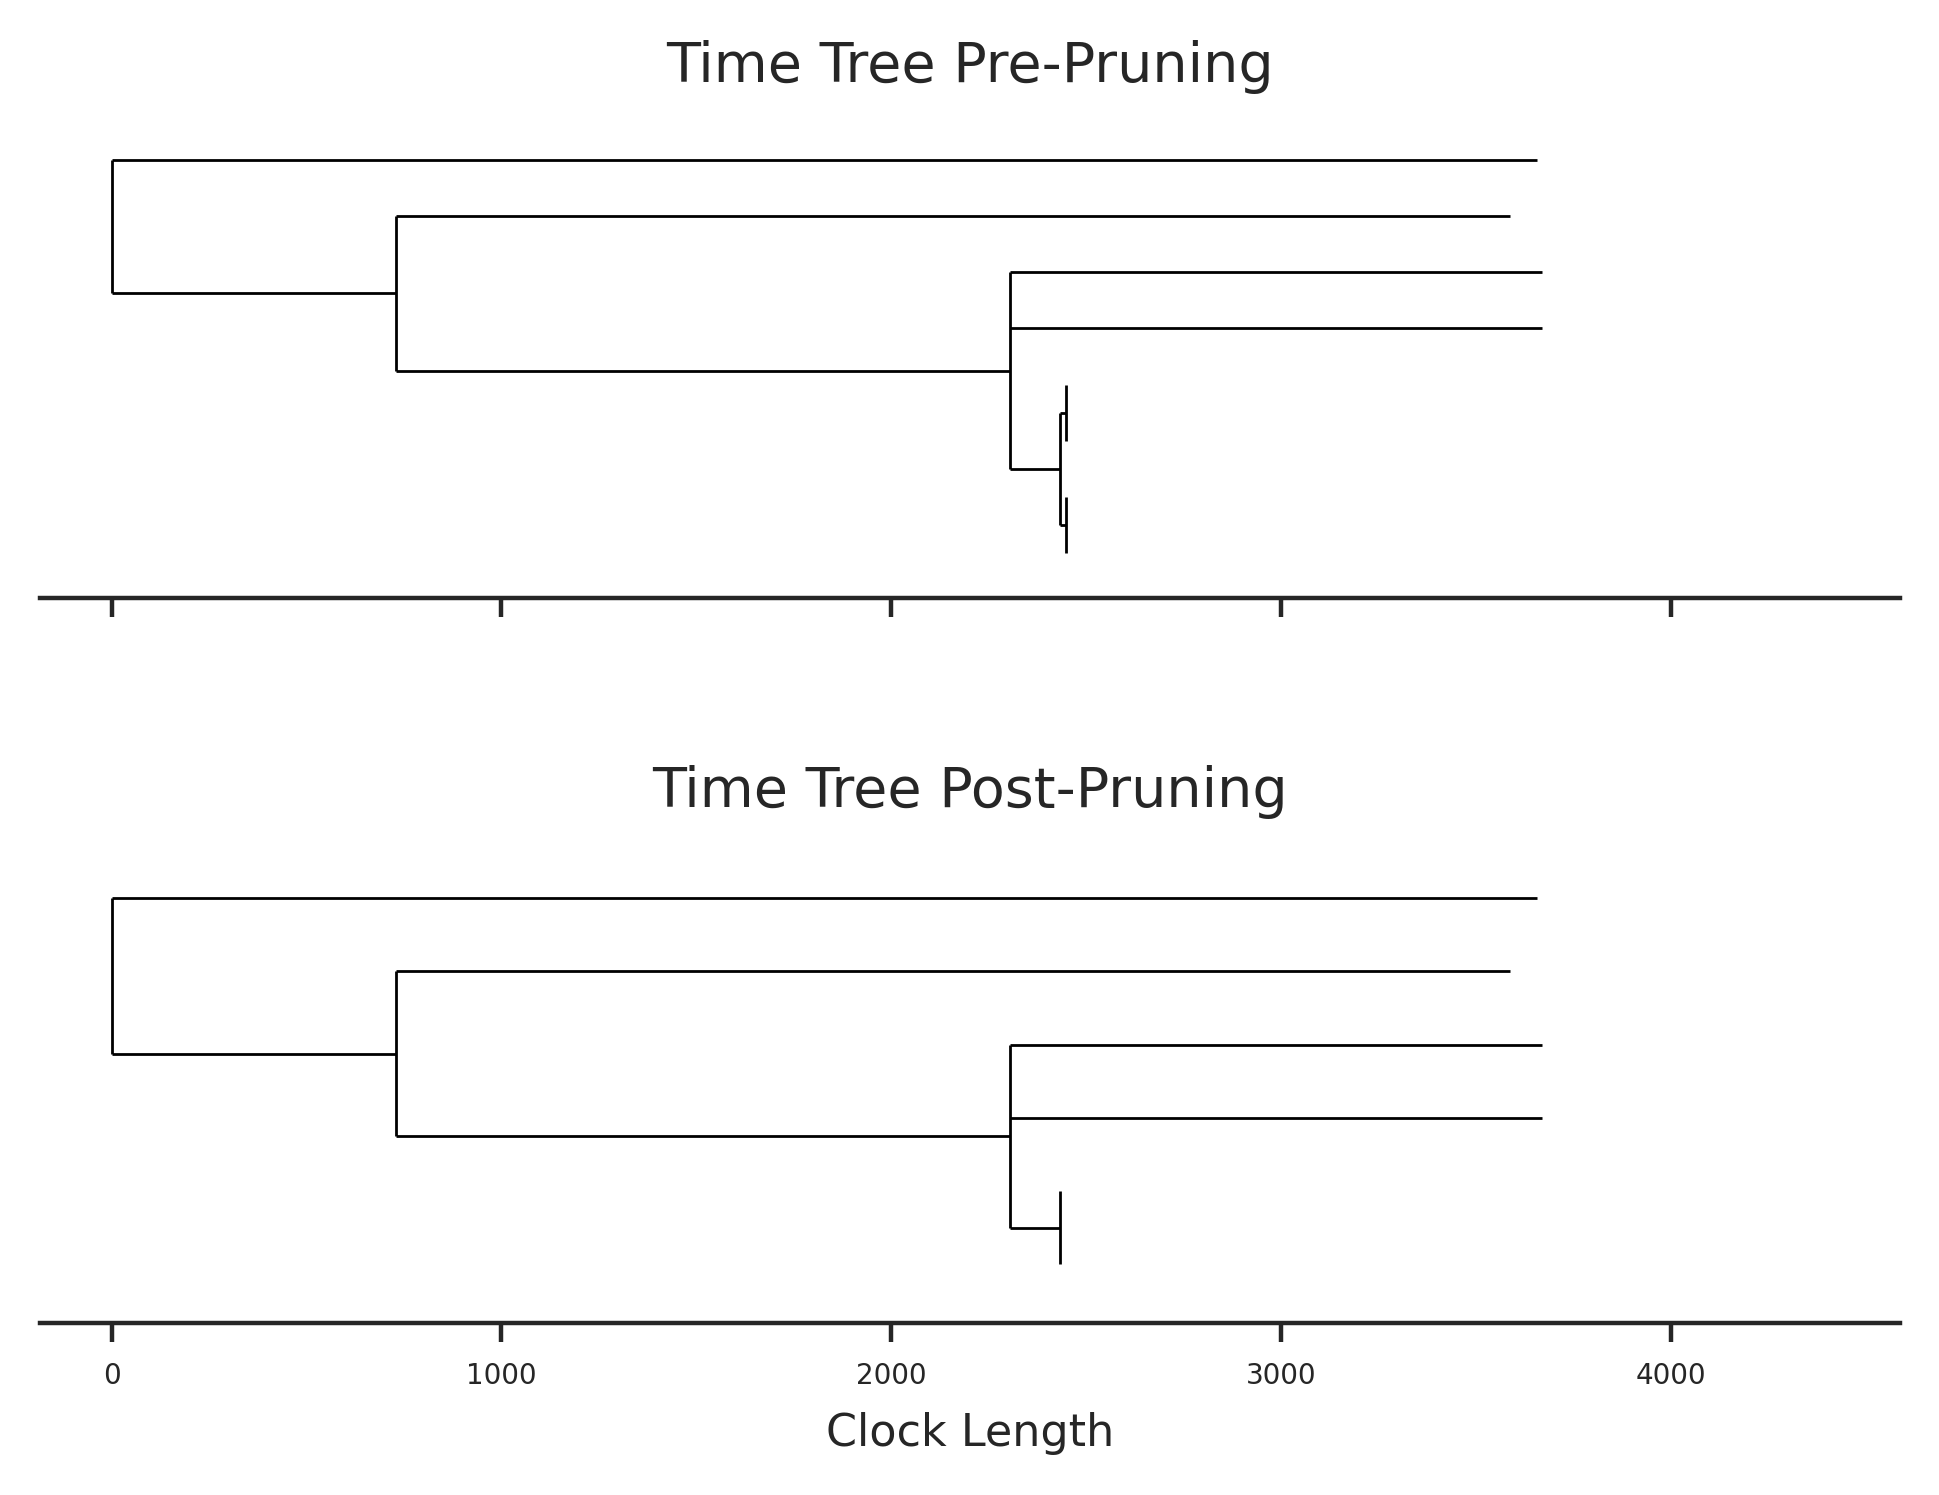

In [17]:
fig, (ax1,ax2) = plt.subplots(2, sharex=True, dpi=dpi)

tt_pre.branch_length_to_years()
tt_prune.branch_length_to_years()

Phylo.draw(tt_pre.tree,   show_confidence=False, label_func = lambda x: '', do_show=False, axes=ax1)  
Phylo.draw(tt_prune.tree, show_confidence=False, label_func = lambda x: '', do_show=False, axes=ax2)

ax1.set_title("Time Tree Pre-Pruning")
ax2.set_title("Time Tree Post-Pruning")

ax1.set_title("Time Tree Pre-Pruning")
ax1.set_xlabel("")
ax1.set_ylabel("")
ax1.set_yticks([])
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["left"].set_visible(False)

ax2.set_title("Time Tree Post-Pruning")
ax2.set_xlabel("Clock Length")
ax2.set_ylabel("")
ax2.set_ylabel("")
ax2.set_yticks([])
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.spines["left"].set_visible(False)

fig.subplots_adjust(hspace=0.5)

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_timetree-prune." + FMT) 
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

## Update tt variable

In [18]:
tt = tt_prune

## Remove Pruned Nodes from Dataframe

In [19]:
tt_nodes = [c.name for c in tt.tree.find_clades()]
for rec in tree_df.iterrows():
    node = rec[0]
    if node not in tt_nodes:
        tree_df.drop(node, inplace=True)
        
tree_df

,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number
Name,,,,,,,,,,,,,,,,,,,,,
NODE0,NA,NA,0.000000e+00,black,0.000000,2.25,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Reference,NA,NA,1.153650e-05,grey,0.000012,1.00,NA,1992,-29,United States of America,Colorado,39.7837,-100.446,38.7252,-105.608,Orientalis,1.ORI,1.ORI1,NA,KEEP: Assembly Modern Reference,1
NODE1,NA,NA,1.153650e-05,black,0.000012,3.50,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
GCA_009909635.1_ASM990963v1_genomic,NA,NA,2.447080e-05,grey,0.000036,2.00,9_10,1923,-98,Russia,Rostov Oblast,64.6863,97.7453,47.6222,40.7958,Medievalis,2.MED,2.MED1,SAMN13632815,KEEP: Assembly Modern,2
NODE2,NA,NA,2.721210e-05,black,0.000039,5.00,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
GCA_009669545.1_ASM966954v1_genomic,NA,NA,2.330000e-08,grey,0.000039,3.00,42126,2006,-15,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722925,KEEP: Assembly Modern,0
GCA_009669555.1_ASM966955v1_genomic,NA,NA,2.331000e-07,grey,0.000039,4.00,42123,2005,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722924,KEEP: Assembly Modern,0
NODE4,NA,NA,4.140200e-06,black,0.000043,6.50,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
SAMN02442718,NA,NA,2.330000e-08,grey,0.000043,5.00,Justinian,[500:800],[-1521:-1221],Germany,Bavaria,51.0834,10.4234,48.9468,11.4039,Orientalis,0.ANT,0.ANT4,SAMN02442718,KEEP: Ancient SRA,0


## Remove Pruned Nodes from Alignment

In [20]:
aln = AlignIO.read(aln_path, "fasta")
filtered_seq = [rec for rec in aln if rec.id in tt_nodes]
new_aln = Align.MultipleSeqAlignment(filtered_seq)

---
# 3. Add Clock Model to Dataframe

- Rates
- Dates
- RTT Regression
- Skyline
- coord_x and coord_y

## Rates

In [21]:
tree_df["timetree_rate"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_rate_fold_change"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_mutation_length"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  

# The mean rate is the slope
mean_rate = tt.clock_model["slope"]

for c in tt.tree.find_clades():
    tree_df.at[c.name, "timetree_mutation_length"] = c.mutation_length
    
    # Relaxed Clock
    if hasattr(c, "branch_length_interpolator") and c.branch_length_interpolator:
        g = c.branch_length_interpolator.gamma
        tree_df.at[c.name, "timetree_rate_fold_change"] = g
        tree_df.at[c.name, "timetree_rate"] = mean_rate * g
        
    # Strict Clock
    else:
        tree_df.at[c.name, "timetree_rate_fold_change"] = 1
        tree_df.at[c.name, "timetree_rate"] = mean_rate

## Dates

In [22]:
# Create new columns
tree_df["timetree_raw_date"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_num_date"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  

if hasattr(tt.tree.root, "marginal_inverse_cdf"):
    tree_df["timetree_num_date_confidence"] = [[NO_DATA_CHAR,NO_DATA_CHAR] for row in range(0,len(tree_df))]
    tree_df["timetree_num_date_bar"] = [[NO_DATA_CHAR,NO_DATA_CHAR] for row in range(0,len(tree_df))]
    
# clock_length is the same as branch_length until running branch_length_to_years()
tree_df["timetree_clock_length"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  

# Make a copy to change branch_length
tt_copy = copy.deepcopy(tt)
tt_copy.branch_length_to_years()

CONF_BAD_RANGE = 10000
CONF_EXTREME = 100000
bad_conf = [["node", "lower_bad", "upper_bad", "lower_corrected", "upper_corrected"]]
        
for c in tt_copy.tree.find_clades():
    # Marginal Probability
    if hasattr(c, "marginal_inverse_cdf"):   
        # Retrieve the region containing the confidence interval
        conf = tt.get_max_posterior_region(c, fraction=CONFIDENCE)
        conf_range = abs(conf[1] - conf[0])
        if conf_range > CONF_BAD_RANGE or conf[0] < -CONF_EXTREME or conf[1] > CONF_EXTREME:
            bad_conf.append([c.name, conf[0], conf[1], c.numdate, c.numdate])
            conf[0] = c.numdate
            conf[1] = c.numdate 
        
        # Set as lower and upper bounds on date
        tree_df.at[c.name, "timetree_num_date_confidence"][0] = conf[0]
        tree_df.at[c.name, "timetree_num_date_confidence"][1] = conf[1]
        
        # Convert to YBP present for drawing bars
        tree_df.at[c.name, "timetree_num_date_bar"][0] = CURRENT_YEAR - conf[0]
        tree_df.at[c.name, "timetree_num_date_bar"][1] = CURRENT_YEAR - conf[1]
        
    tree_df.at[c.name, "timetree_raw_date"] = c.date  
    tree_df.at[c.name, "timetree_num_date"] = c.numdate
    tree_df.at[c.name, "timetree_clock_length"] = c.branch_length
    
out_path_bad_conf = os.path.join(outdir, SCRIPT_NAME + "_bad-confidence.tsv")
with open(out_path_bad_conf, "w") as outfile:
    for node in bad_conf:
        print("\t".join([str(n) for n in node]))
        outfile.write("\t".join([str(n) for n in node]) + "\n")

node	lower_bad	upper_bad	lower_corrected	upper_corrected


In [23]:
tt.get_max_posterior_region(tt_copy.tree.root, fraction=CONFIDENCE) - CURRENT_YEAR

array([-3791.55333063, -3205.55802803])

## RTT

In [24]:
# make a copy of the tree
tt_copy = copy.deepcopy(tt)
tt_copy.branch_length_to_years()

# Plotting the tree
tree_df["timetree_coord_x"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_coord_y"] = [NO_DATA_CHAR for row in range(0,len(tree_df))] 

# Plotting the regression
tree_df["timetree_reg_x"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_reg_y"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_reg_bad"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  

x_posns = get_x_positions(tt_copy.tree)
y_posns = get_y_positions(tt_copy.tree)
tt_reg = tt_copy.setup_TreeRegression()

# Add x and y coordinates
for c in tt_copy.tree.find_clades():     
        
    # Tree Node Coordinates
    coord_x = [value for key,value in x_posns.items() if key.name == c.name][0]
    coord_y = [value for key,value in y_posns.items() if key.name == c.name][0]
    tree_df.at[c.name, 'timetree_coord_x'] = coord_x
    tree_df.at[c.name, 'timetree_coord_y'] = coord_y
    
    # Regression Node Coordinates
    reg_y = c._v
    if c.is_terminal():
        reg_x = tt_reg.tip_value(c)
    else:
        reg_x = c.numdate
    reg_bad = c.bad_branch  if hasattr(c, 'bad_branch') else False
    tree_df.at[c.name, 'timetree_reg_x'] = reg_x
    tree_df.at[c.name, 'timetree_reg_y'] = reg_y    
    tree_df.at[c.name, 'timetree_reg_bad'] = reg_bad

# Fix up new values that could be none
tree_df.fillna(NO_DATA_CHAR, inplace=True)
tree_df

,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number,timetree_rate,timetree_rate_fold_change,timetree_mutation_length,timetree_raw_date,timetree_num_date,timetree_num_date_confidence,timetree_num_date_bar,timetree_clock_length,timetree_coord_x,timetree_coord_y,timetree_reg_x,timetree_reg_y,timetree_reg_bad
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NODE0,NA,NA,0.000000e+00,black,0.000000,2.25,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,-8.723888e-09,1.000000,1.000000e-03,-1664-08-14,-1663.381162,"[-1770.553330625422, -1184.5580280260137]","[3791.553330625422, 3205.5580280260137]",0.100000,0.100000,2.0625,-1663.381162,0.000000,False
Reference,NA,NA,1.153650e-05,grey,0.000012,1.00,NA,1992,-29,United States of America,Colorado,39.7837,-100.446,38.7252,-105.608,Orientalis,1.ORI,1.ORI1,NA,KEEP: Assembly Modern Reference,1,-2.793677e-09,0.320233,1.024114e-05,1992-01-01,1992.000000,"[1992.0, 1992.0]","[29.0, 29.0]",3655.381162,3655.481162,1.0000,1992.000000,0.000010,False
NODE1,NA,NA,1.153650e-05,black,0.000012,3.50,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,-1.490097e-08,1.708065,1.088119e-05,-935-09-01,-934.331678,"[-1502.4170624140174, -920.2684350661721]","[3523.4170624140174, 2941.268435066172]",729.049484,729.149484,3.1250,-934.331678,0.000011,False
GCA_009909635.1_ASM990963v1_genomic,NA,NA,2.447080e-05,grey,0.000036,2.00,9_10,1923,-98,Russia,Rostov Oblast,64.6863,97.7453,47.6222,40.7958,Medievalis,2.MED,2.MED1,SAMN13632815,KEEP: Assembly Modern,2,-7.806298e-09,0.894819,2.240270e-05,1923-01-01,1923.000000,"[1923.0, 1923.0]","[98.0, 98.0]",2857.331678,3586.481162,2.0000,1923.000000,0.000033,False
NODE2,NA,NA,2.721210e-05,black,0.000039,5.00,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,-1.570142e-08,1.799819,2.496297e-05,0641-06-18,641.460969,"[343.58792289143526, 654.2862301985285]","[1677.4120771085647, 1366.7137698014715]",1575.792647,2304.942131,4.2500,641.460969,0.000036,False
GCA_009669545.1_ASM966954v1_genomic,NA,NA,2.330000e-08,grey,0.000039,3.00,42126,2006,-15,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722925,KEEP: Assembly Modern,0,-8.723888e-10,0.100000,9.304868e-19,2006-01-01,2006.000000,"[2006.0, 2006.0]","[15.0, 15.0]",1364.539031,3669.481162,3.0000,2006.000000,0.000036,False
GCA_009669555.1_ASM966955v1_genomic,NA,NA,2.331000e-07,grey,0.000039,4.00,42123,2005,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722924,KEEP: Assembly Modern,0,-8.723888e-10,0.100000,2.133570e-07,2005-01-01,2005.000000,"[2005.0, 2005.0]","[16.0, 16.0]",1363.539031,3668.481162,4.0000,2005.000000,0.000036,False
NODE4,NA,NA,4.140200e-06,black,0.000043,6.50,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,-3.151104e-08,3.612041,4.267122e-06,0769-04-26,769.315964,"[618.8328686071859, 764.7252100483174]","[1402.167131392814, 1256.2747899516826]",127.854996,2432.797127,5.5000,769.315964,0.000040,False
SAMN02442718,NA,NA,2.330000e-08,grey,0.000043,5.00,Justinian,[500:800],[-1521:-1221],Germany,Bavaria,51.0834,10.4234,48.9468,11.4039,Orientalis,0.ANT,0.ANT4,SAMN02442718,KEEP: Ancient SRA,0,-8.723888e-09,1.000000,9.296379e-19,0783-11-02,783.836846,"[781.4403633771801, 800.0]","[1239.5596366228199, 1221.0]",0.000000,2432.797127,5.0000,650.000000,0.000040,False


## Divergence coord_x and coord_y

In [25]:
tt_copy = copy.deepcopy(tt)
for n in tt_copy.tree.find_clades():
    n.branch_length=n.mutation_length
    
x_posns = get_x_positions(tt_copy.tree)
y_posns = get_y_positions(tt_copy.tree)

# Add x and y coordinates as other attributes
for c in tt_copy.tree.find_clades():
    # x coordinates will be of branch length units
    coord_x = [value for key,value in x_posns.items() if key.name == c.name][0]
    # y coordinates will be arbitrary, based on number of tips
    coord_y = [value for key,value in y_posns.items() if key.name == c.name][0]
    # Update coordinates in dataframe
    tree_df.at[c.name, 'coord_x'] = coord_x
    tree_df.at[c.name, 'coord_y'] = coord_y    

# Visualize dataframe
tree_df

,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number,timetree_rate,timetree_rate_fold_change,timetree_mutation_length,timetree_raw_date,timetree_num_date,timetree_num_date_confidence,timetree_num_date_bar,timetree_clock_length,timetree_coord_x,timetree_coord_y,timetree_reg_x,timetree_reg_y,timetree_reg_bad
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NODE0,NA,NA,0.000000e+00,black,0.001000,2.0625,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,-8.723888e-09,1.000000,1.000000e-03,-1664-08-14,-1663.381162,"[-1770.553330625422, -1184.5580280260137]","[3791.553330625422, 3205.5580280260137]",0.100000,0.100000,2.0625,-1663.381162,0.000000,False
Reference,NA,NA,1.153650e-05,grey,0.001010,1.0000,NA,1992,-29,United States of America,Colorado,39.7837,-100.446,38.7252,-105.608,Orientalis,1.ORI,1.ORI1,NA,KEEP: Assembly Modern Reference,1,-2.793677e-09,0.320233,1.024114e-05,1992-01-01,1992.000000,"[1992.0, 1992.0]","[29.0, 29.0]",3655.381162,3655.481162,1.0000,1992.000000,0.000010,False
NODE1,NA,NA,1.153650e-05,black,0.001011,3.1250,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,-1.490097e-08,1.708065,1.088119e-05,-935-09-01,-934.331678,"[-1502.4170624140174, -920.2684350661721]","[3523.4170624140174, 2941.268435066172]",729.049484,729.149484,3.1250,-934.331678,0.000011,False
GCA_009909635.1_ASM990963v1_genomic,NA,NA,2.447080e-05,grey,0.001033,2.0000,9_10,1923,-98,Russia,Rostov Oblast,64.6863,97.7453,47.6222,40.7958,Medievalis,2.MED,2.MED1,SAMN13632815,KEEP: Assembly Modern,2,-7.806298e-09,0.894819,2.240270e-05,1923-01-01,1923.000000,"[1923.0, 1923.0]","[98.0, 98.0]",2857.331678,3586.481162,2.0000,1923.000000,0.000033,False
NODE2,NA,NA,2.721210e-05,black,0.001036,4.2500,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,-1.570142e-08,1.799819,2.496297e-05,0641-06-18,641.460969,"[343.58792289143526, 654.2862301985285]","[1677.4120771085647, 1366.7137698014715]",1575.792647,2304.942131,4.2500,641.460969,0.000036,False
GCA_009669545.1_ASM966954v1_genomic,NA,NA,2.330000e-08,grey,0.001036,3.0000,42126,2006,-15,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722925,KEEP: Assembly Modern,0,-8.723888e-10,0.100000,9.304868e-19,2006-01-01,2006.000000,"[2006.0, 2006.0]","[15.0, 15.0]",1364.539031,3669.481162,3.0000,2006.000000,0.000036,False
GCA_009669555.1_ASM966955v1_genomic,NA,NA,2.331000e-07,grey,0.001036,4.0000,42123,2005,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722924,KEEP: Assembly Modern,0,-8.723888e-10,0.100000,2.133570e-07,2005-01-01,2005.000000,"[2005.0, 2005.0]","[16.0, 16.0]",1363.539031,3668.481162,4.0000,2005.000000,0.000036,False
NODE4,NA,NA,4.140200e-06,black,0.001040,5.5000,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,-3.151104e-08,3.612041,4.267122e-06,0769-04-26,769.315964,"[618.8328686071859, 764.7252100483174]","[1402.167131392814, 1256.2747899516826]",127.854996,2432.797127,5.5000,769.315964,0.000040,False
SAMN02442718,NA,NA,2.330000e-08,grey,0.001040,5.0000,Justinian,[500:800],[-1521:-1221],Germany,Bavaria,51.0834,10.4234,48.9468,11.4039,Orientalis,0.ANT,0.ANT4,SAMN02442718,KEEP: Ancient SRA,0,-8.723888e-09,1.000000,9.296379e-19,0783-11-02,783.836846,"[781.4403633771801, 800.0]","[1239.5596366228199, 1221.0]",0.000000,2432.797127,5.0000,650.000000,0.000040,False


## Add Metadata as Comments

In [26]:
metadata_to_comment(tt.tree, tree_df)

---
# Export

## GTR Model

In [27]:
out_path_gtr = os.path.join(outdir, SCRIPT_NAME + "_gtr.txt" )
gtr_model_str = str(tt.gtr)
with open(out_path_gtr,"w") as outfile:
    outfile.write(gtr_model_str)

## Alignment

In [28]:
out_path_aln = os.path.join(outdir, SCRIPT_NAME + ".fasta" )
with open(out_path_aln, "w") as outfile:
    count = SeqIO.write(new_aln, outfile, "fasta")
    print(count, "alignments written.")

6 alignments written.


## Dataframe

In [29]:
# Dataframe
out_path_df = os.path.join(outdir, SCRIPT_NAME + ".tsv" )
out_path_pickle_df = os.path.join(outdir,  SCRIPT_NAME + ".df.obj" )

tree_df.to_csv(out_path_df, sep="\t")
with open(out_path_pickle_df,"wb") as outfile:
    dill.dump(tree_df, outfile)

## Timetrees

In [30]:
tt_copy = copy.deepcopy(tt)

# Nexus
out_path_nexus = os.path.join(outdir, SCRIPT_NAME + "_timetree.nexus" )
Phylo.write(tt_copy.tree, out_path_nexus, 'nexus', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

# Dill object
out_path_dill_tree = os.path.join(outdir,  SCRIPT_NAME + "_timetree.treetime.obj" )
with open(out_path_dill_tree,"wb") as outfile:
    dill.dump(tt_copy, outfile)
    
# Newick (remove comments)
for c in tt_copy.tree.find_clades(): c.comment = None
out_path_nwk = os.path.join(outdir, SCRIPT_NAME + "_timetree.nwk" )
Phylo.write(tt_copy.tree, out_path_nwk, 'newick', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))


1

## Divtrees

In [31]:
tt_copy = copy.deepcopy(tt)
# Convert to divtree
for n in tt_copy.tree.find_clades():
    n.branch_length=n.mutation_length

# Nexus
out_path_nexus = os.path.join(outdir, SCRIPT_NAME + "_divtree.nexus" )
Phylo.write(tt_copy.tree, out_path_nexus, 'nexus', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

# Dill object
out_path_dill_tree = os.path.join(outdir,  SCRIPT_NAME + "_divtree.treetime.obj" )
with open(out_path_dill_tree,"wb") as outfile:
    dill.dump(tt_copy, outfile)
    
# Newick (remove comments)
for c in tt_copy.tree.find_clades(): c.comment = None
out_path_nwk = os.path.join(outdir, SCRIPT_NAME + "_divtree.nwk" )
Phylo.write(tt_copy.tree, out_path_nwk, 'newick', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

1

## Augur JSON

In [32]:
augur_dict = augur_export(
    tree_path=out_path_nwk, 
    aln_path=aln_path, 
    tree=tt.tree,     
    #tree=tree_div, 
    tree_df=tree_df, 
    color_keyword_exclude=["color", "coord", "reg", "lat", "lon"],
    type_convert = {
        "Branch_Number" : (lambda x : str(x))
    },
)

print(augur_dict["nodes"]["Reference"])

if hasattr(tt, "merger_model"):
    try:
        skyline, conf = tt.merger_model.skyline_inferred(gen=50, confidence=2)
        augur_dict['skyline'] = [[float(x) for x in skyline.x], [float(y) for y in conf[0]],
                           [float(y) for y in skyline.y], [float(y) for y in conf[1]]]
    except TypeError:
        pass

out_path_augur_json = os.path.join(outdir, SCRIPT_NAME + "_augur.json" )
utils.write_json(data=augur_dict, file_name=out_path_augur_json, indent=JSON_INDENT)

{'ufboot': 'NA', 'scf': 'NA', 'branch_length': 1.15365e-05, 'strain': 'NA', 'date': 1992.0, 'datebp': -29.0, 'country': 'United States of America', 'province': 'Colorado', 'biovar': 'Orientalis', 'branch_major': '1.ORI', 'branch_minor': '1.ORI1', 'biosample': 'NA', 'biosamplecomment': 'KEEP: Assembly Modern Reference', 'branch_number': '1', 'rate': -2.793676743401006e-09, 'rate_fold_change': 0.3202329773099398, 'mutation_length': 1.0241138846643053e-05, 'raw_date': '1992-01-01', 'num_date': 1992.0, 'num_date_confidence': [1992.0, 1992.0], 'num_date_bar': '29.0:29.0', 'clock_length': 3655.3811624598793}


## Auspice JSON

In [33]:
auspice_dict = auspice_export(
    tree=tt.tree, 
    augur_json_paths=[out_path_augur_json], 
    auspice_config_path=auspice_config_path, 
    auspice_colors_path=auspice_colors_path,
    auspice_latlons_path=auspice_latlon_path, 
    )

# Write outputs - For Local Rendering
out_path_auspice_local_json = os.path.join(outdir, SCRIPT_NAME + "_auspice.json" )
utils.write_json(data=auspice_dict, file_name=out_path_auspice_local_json, indent=JSON_INDENT, include_version=False)
export_v2.validate_data_json(out_path_auspice_local_json)
print("Validation successful for local JSON.")

# Write outputs - For Remote Rendering
#out_path_auspice_remote_json = os.path.join(auspice_remote_dir_path, AUSPICE_PREFIX + SCRIPT_NAME.replace("_","-") + ".json" )
#utils.write_json(data=auspice_dict, file_name=out_path_auspice_remote_json, indent=JSON_INDENT, include_version=False)
#export_v2.validate_data_json(out_path_auspice_remote_json)
#print("Validation successful for remote JSON.")

<class 'dict'>
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/config/auspice_config.json'...
Validation success.
Validating produced JSON
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/clock/all/chromosome_filter50/clock_model_auspice.json'...
Validating that the JSON is internally consistent...
Validation of '/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/clock/all/chromosome_filter50/clock_model_auspice.json' succeeded, but there were warnings you may want to resolve.
Validation successful for local JSON.


## BEAST

### Nexus

Without comment, internal nodes names, or multifurcations

In [65]:
# Timetree
tt_copy = copy.deepcopy(tt)
MIN_BRANCH_LENGTH = tt_copy.tree.root.branch_length

# Fix comments and internal nodes names
for c in tt_copy.tree.find_clades(): 
    # Remove comments
    c.comment = None
    # Remove internal node names
    if "NODE" in c.name:
        c.name = None

# Fix multifurcations and zero
t = Tree(tt_copy.tree.format("newick"))
t.standardize()
t_nwk = Phylo.read(io.StringIO(t.write(format = 0)), "newick")

for c in t_nwk.find_clades():
    if not c.branch_length or c.branch_length < MIN_BRANCH_LENGTH:
        c.branch_length = MIN_BRANCH_LENGTH
        
out_path_beast_time = os.path.join(outdir, SCRIPT_NAME + "_beast_timetree.nex" )
Phylo.write(t_nwk, out_path_beast_time, 'nexus')

1

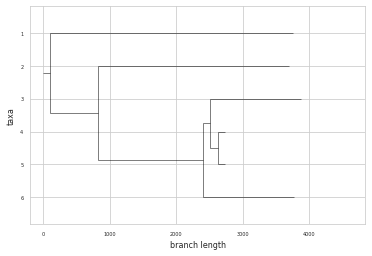

In [64]:
Phylo.draw(t_nwk,   show_confidence=False, label_func = lambda x: '', do_show=False)  